In [1]:
import os
import urllib, cStringIO

import pymongo as pm

from IPython.display import clear_output

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import json
import analysis_helpers as h
reload(h)

## get standardized object list
categories = ['bird','car','chair','dog']
obj_list = []
for cat in categories:
    for i,j in h.objcat.iteritems():
        if j==cat:
            obj_list.append(i)   

### load in model param posterior (bdaOutput/**splitbyobjectParams.csv)

In [2]:
def model_comparison_bars(model_prefixes,adaptor_type='human',split_type='balancedavg'):
    all_param_paths = sorted(os.listdir('../models/bdaOutput/{}_{}/raw/'.format(adaptor_type,split_type)))
    model_zoo = [i for i in all_param_paths for pre in model_prefixes if pre in i]
    model_zoo = [i for i in model_zoo if i[-1] != '~']
    model_zoo = [i for i in model_zoo if '.csv' in i]
    model_zoo = [i for i in model_zoo if 'S1' not in i.split('_')] ## do not consider S1
    
#     assert len(model_zoo) == len(model_prefixes)*4
    
    import analysis_helpers as h
    reload(h)

    LL = []
    model_name = []
    for this_model in model_zoo:

        ## define paths to model predictions
        if adaptor_type=='human':
            model_dirname = ('_').join(this_model.split('_')[:3])
        else:
            model_dirname = ('_').join(this_model.split('_')[:4])

        ## get file with params from this model
        this_params = os.path.join('../models/bdaOutput/{}_{}/raw/'.format(adaptor_type,split_type),this_model)
        params = pd.read_csv(this_params)
        assert np.round(np.sum(np.exp(params.posteriorProb.values)),12)==1

        ## append MAP LL
        LL.append(params.sort_values(by=['logLikelihood'],ascending=False).iloc[0]['logLikelihood'])
        model_name.append(model_dirname) 
        
    ## make dataframe
    PP = pd.DataFrame.from_records(zip(model_name,LL))
    PP.columns=['model','logLikelihood']
    if adaptor_type=='human':
        PP['perception'], PP['pragmatics'], PP['production'] = PP['model'].str.split('_', 3).str
    else:
        PP['adaptor'],PP['perception'], PP['pragmatics'], PP['production'] = PP['model'].str.split('_', 3).str
    return PP        
    
    
def plot_human_bars(PP):
    sns.factorplot(data=PP,x='pragmatics',y='logLikelihood',
                   hue='production',kind='bar',
                   order=['S0','combined'],
                   hue_order=['nocost','cost'],
                   palette='Paired',
                   legend=False,
                   ci=None)
    plt.ylabel('log likelihood')
    locs, labels = plt.xticks([0,1],['insensitive','sensitive'],fontsize=14)
    plt.xlabel('context')
    # plt.ylim([-3000,0])
    plt.tight_layout()
    plt.savefig('./plots/loglikelihood_models_human.pdf')
    # plt.close()  
    
def plot_multimodal_bars(PP):
    sns.factorplot(data=PP,x='perception',y='logLikelihood',
                   hue='pragmatics',kind='bar',
                   order=['pool1','conv42','fc6'],
                   palette='Paired',
                   legend=False,
                   ci=None)
    plt.ylabel('log likelihood')
    locs, labels = plt.xticks([0,1,2],['early','mid','high'],fontsize=14)
    plt.xlabel('visual features')
    # plt.ylim([-3000,0])
    plt.tight_layout()
    plt.savefig('./plots/loglikelihood_models_multimodal.pdf')
    # plt.close()      
    
def flatten_mcmc_to_samples(raw_params,num_samples=1000):
    flat_params = pd.DataFrame(columns=raw_params.columns)
    counter = 0
    for i,d in raw_params.iterrows():
        multiples = int(np.round(np.exp(d['posteriorProb'])*num_samples))
        for m in np.arange(multiples):
            flat_params.loc[counter] = d
            counter += 1

    ## correct the posteriorProb column so that each sample has prob 1/num_samples, where num_samples prob is 1000
    flat_params.drop(labels=['posteriorProb'], axis="columns", inplace=True)
    flat_params['posteriorProb'] = np.tile(np.log(1/num_samples),len(flat_params))
    assert len(flat_params)==num_samples
    return flat_params    

#### make loglikelihood plot for human encoder version

/home/jefan/.local/lib/python2.7/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


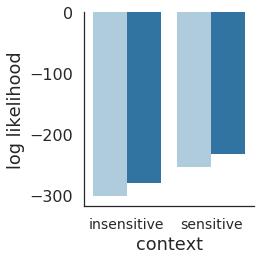

In [3]:
model_prefixes = ['human']
PP = model_comparison_bars(model_prefixes,adaptor_type='human')
plot_human_bars(PP)

In [4]:
PP

,model,logLikelihood,perception,pragmatics,production
0,human_S0_cost,-280.872004,human,S0,cost
1,human_S0_nocost,-302.543329,human,S0,nocost
2,human_combined_cost,-232.667310,human,combined,cost
3,human_combined_nocost,-254.589197,human,combined,nocost


#### make loglikelihood plot for multimodal convnet encoder version

In [5]:
adaptor_type = 'multimodal_fc6'
split_type = '5'
# model_prefixes = ['multimodal_pool1','multimodal_conv42','multimodal_fc6']
model_prefixes = ['multimodal_fc6']
PP = model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type='balancedavg{}'.format(split_type))
# plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_fc6_S0_cost,-529.387706,multimodal,fc6,S0,cost
1,multimodal_fc6_S0_nocost,-541.599460,multimodal,fc6,S0,nocost
2,multimodal_fc6_combined_cost,-459.396108,multimodal,fc6,combined,cost
3,multimodal_fc6_combined_nocost,-475.055630,multimodal,fc6,combined,nocost


In [6]:
adaptor_type = 'multimodal_conv42'
split_type = '1'
# model_prefixes = ['multimodal_pool1','multimodal_conv42','multimodal_fc6']
model_prefixes = ['multimodal_conv42']
PP = model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type='balancedavg{}'.format(split_type))
# plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_conv42_S0_cost,-761.169049,multimodal,conv42,S0,cost
1,multimodal_conv42_S0_nocost,-764.507757,multimodal,conv42,S0,nocost
2,multimodal_conv42_combined_cost,-704.875318,multimodal,conv42,combined,cost
3,multimodal_conv42_combined_nocost,-707.750224,multimodal,conv42,combined,nocost


In [7]:
adaptor_type = 'multimodal_pool1'
split_type = '1'
# model_prefixes = ['multimodal_pool1','multimodal_conv42','multimodal_fc6']
model_prefixes = ['multimodal_pool1']
PP = model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type='balancedavg{}'.format(split_type))
# plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_pool1_S0_cost,-1125.247508,multimodal,pool1,S0,cost
1,multimodal_pool1_S0_nocost,-1116.701463,multimodal,pool1,S0,nocost
2,multimodal_pool1_combined_cost,-1105.747792,multimodal,pool1,combined,cost
3,multimodal_pool1_combined_nocost,-1106.212754,multimodal,pool1,combined,nocost


In [23]:
model_prefixes = ['multimodal_fc6']
adaptor_type = 'multimodal_fc6'
split_type = 'balancedavg5'
all_param_paths = sorted(os.listdir('../models/bdaOutput/{}_{}/raw'.format(adaptor_type,split_type)))
model_zoo = [i for i in all_param_paths for pre in model_prefixes if pre in i]
model_zoo = [i for i in model_zoo if i[-1] != '~']
model_zoo = [i for i in model_zoo if '.csv' in i]
# model_zoo = [i for i in model_zoo if 'S1' not in i.split('_')] ## do not consider S1

# assert len(model_zoo) == len(model_prefixes)*6

import analysis_helpers as h
reload(h)

## get file with params from this model
this_params = os.path.join('../models/bdaOutput/{}_{}'.format(adaptor_type,split_type),'raw',model_zoo[4])
params1 = pd.read_csv(this_params)

this_params = os.path.join('../models/bdaOutput/{}_{}'.format(adaptor_type,split_type),'raw',model_zoo[5])
params2 = pd.read_csv(this_params)

## "flatten" params file so that we have all 1000 samples in the params file itself
fparams1 = flatten_mcmc_to_samples(params1)
fparams2 = flatten_mcmc_to_samples(params2)
fparams1.reset_index(inplace=True,drop=True)
fparams2.reset_index(inplace=True,drop=True)

print '{} cost version mean LL: {}'.format(adaptor_type, np.mean(fparams1.logLikelihood.values))
print '{} nocost version mean LL: {}'.format(adaptor_type, np.mean(fparams2.logLikelihood.values))

multimodal_fc6 cost version mean LL: -461.467482456
multimodal_fc6 nocost version mean LL: -476.349799562


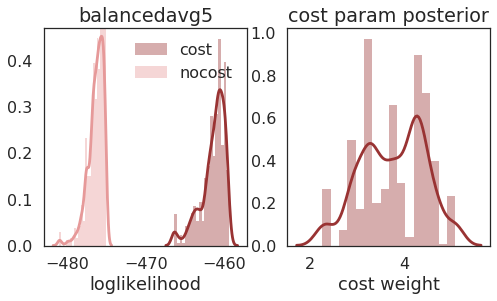

In [24]:
## plot LL distribution comparing cost and nocost verisons
plt.figure(figsize=(8,4))
plt.subplot(121)
h = sns.distplot(fparams1.logLikelihood.values,color=(0.6,0.2,0.2),label='cost')
h = sns.distplot(fparams2.logLikelihood.values,color=(0.9,0.6,0.6),label='nocost')
plt.xlabel('loglikelihood')
# plt.xlim(-650,-400)
plt.title(split_type)
plt.legend()

## plot cost weight distribution
plt.subplot(122)
h = sns.distplot(fparams1.costWeight.values,color=(0.6,0.2,0.2))
plt.title('cost param posterior')
plt.xlabel('cost weight')

### Run evaluate to get scores on the test set

In [372]:
### FIRST STEP:
### iterate through Params and write back out in "flattened" form
# adaptor_types = ['multimodal_pool1','multimodal_conv42','multimodal_fc6']
adaptor_types = ['human']
model_prefixes = adaptor_types
split_types = ['balancedavg{}'.format(i) for i in map(str,np.arange(1,6))]

for adaptor_type in adaptor_types:
    for split_type in split_types:
        all_param_paths = sorted(os.listdir('../models/bdaOutput/{}_{}/raw'.format(adaptor_type,split_type)))
        model_zoo = [i for i in all_param_paths for pre in model_prefixes if pre in i]
        model_zoo = [i for i in model_zoo if i[-1] != '~']
        model_zoo = [i for i in model_zoo if '.csv' in i]    

        for i,model in enumerate(model_zoo):
            print 'flattening {}'.format(model)
            ## get file with params from this model
            this_params = os.path.join('../models/bdaOutput/{}_{}'.format(adaptor_type,split_type),'raw',model)
            params = pd.read_csv(this_params)

            ## "flatten" params file so that we have all 1000 samples in the params file itself
            fparams = flatten_mcmc_to_samples(params)
            fparams.reset_index(inplace=True,drop=True)
            fparams = fparams.rename(columns={'id':'sample_id'}) ## rename id column to be sample id
            fparams = fparams.reindex(fparams.index.rename('id')) ## rename index column to be id column

            ## write out
            out_path = os.path.join('../models/bdaOutput/{}_{}'.format(adaptor_type,split_type),'flattened',model.split('.')[0] + 'Flattened.csv')
            if not os.path.exists(os.path.join('../models/bdaOutput/{}_{}'.format(adaptor_type,split_type),'flattened')):
                os.makedirs(os.path.join('../models/bdaOutput/{}_{}'.format(adaptor_type,split_type),'flattened'))
            print 'out_path = {}'.format(out_path)
            fparams.to_csv(out_path)
    

flattening human_S0_cost_balancedavg1Params.csv
out_path = ../models/bdaOutput/human_balancedavg1/flattened/human_S0_cost_balancedavg1ParamsFlattened.csv
flattening human_S0_nocost_balancedavg1Params.csv
out_path = ../models/bdaOutput/human_balancedavg1/flattened/human_S0_nocost_balancedavg1ParamsFlattened.csv
flattening human_S1_cost_balancedavg1Params.csv
out_path = ../models/bdaOutput/human_balancedavg1/flattened/human_S1_cost_balancedavg1ParamsFlattened.csv
flattening human_S1_nocost_balancedavg1Params.csv
out_path = ../models/bdaOutput/human_balancedavg1/flattened/human_S1_nocost_balancedavg1ParamsFlattened.csv
flattening human_combined_cost_balancedavg1Params.csv
out_path = ../models/bdaOutput/human_balancedavg1/flattened/human_combined_cost_balancedavg1ParamsFlattened.csv
flattening human_combined_nocost_balancedavg1Params.csv
out_path = ../models/bdaOutput/human_balancedavg1/flattened/human_combined_nocost_balancedavg1ParamsFlattened.csv
flattening human_S0_cost_balancedavg2Par

### check model predictions 

- retrieval
- cost plot

In [ ]:
import analysis_helpers as h
reload(h)

split_types = ['balancedavg1','balancedavg2','balancedavg3','balancedavg4','balancedavg5']

model_space = ['human_combined_cost','multimodal_fc6_combined_cost','multimodal_conv42_combined_cost',
              'multimodal_fc6_S0_cost','multimodal_fc6_combined_nocost']

# split_types = ['balancedavg5']
# model_space = ['multimodal_fc6_combined_cost']

# ## define paths to model predictions
# split_type = 'balancedavg1'
# model = 'multimodal_conv42_combined_cost'

for model in model_space[2:]:
    for split_type in split_types:

        path_to_evaluate = '/data2/jefan/sketchpad_basic_model_output/evaluateOutput/{}_{}'.format(model,split_type)
        pred_files = [os.path.join(path_to_evaluate,i) for i in os.listdir(path_to_evaluate)]

        ## get file with params from this model
        if model.split('_')[0]=='human':
            bdaOutDir = '_'.join(model.split('_')[:1]) + '_{}'.format(split_type)
        else:
            bdaOutDir = '_'.join(model.split('_')[:2]) + '_{}'.format(split_type)
        params_fname = model + '_' + split_type + 'ParamsFlattened.csv'
        params_path = os.path.join('../models/bdaOutput',bdaOutDir,'flattened',params_fname)
        params = pd.read_csv(params_path)
        assert np.round(np.sum(np.exp(params.posteriorProb.values)),12)==1

        ## get list of all predictives (accepted MCMC samples) and
        h.sort_filelist(pred_files) ## sort pred_files into human ordering


        Obj = []
        Cond = []
        TargetRank = []
        FoilRank = []
        Logprob = []
        SampleID = []
        Trial = []

        ## loop through MCMC samples
        for i,this_sample in enumerate(pred_files):
            print 'Currently evaluating {} {}'.format(model,split_type)
            print'{} | sample ID: {} '.format(i,int(this_sample.split('/')[-1].split('Predictives.csv')[0]))

            ## read in predictions from this sample        
            sample_preds = pd.read_csv(this_sample)
            sample_ind = int(this_sample.split('/')[-1].split('Predictives.csv')[0]) ## index of MCMC sample
            clear_output(wait=True)        

            ## get params that generated these predictions
        #     simScaling = params.iloc[sample_ind]['simScaling']
        #     pragWeight = params.iloc[sample_ind]['pragWeight']
        #     costWeight = params.iloc[sample_ind]['costWeight']
        #     infWeight = params.iloc[sample_ind]['infWeight']    
        #     posteriorProb = params.iloc[sample_ind]['posteriorProb']
        #     logLikelihood = params.iloc[sample_ind]['logLikelihood']        

            ## get congruent/incongruent context log odds for each sketch
            trials = np.unique(sample_preds['game'].values)

            for this_trial in trials:
                ## subset the rows that correspond to this particular trial
                trial_inds = sample_preds['game']==this_trial
                these_rows = sample_preds[trial_inds]

                assert np.round(sum(np.exp(these_rows['modelProb'].values)),6)==1

                ## sort the 64 sketch categories by model probability 
                sorted_rows = these_rows.sort_values(by=['modelProb'],ascending=False).reset_index()

                ## get target rank, logprob, prob
                target = np.unique(sorted_rows['TrueSketch'].values)[0]
                if target.split('_')[0]=='closer':
                    foil = 'further_{}'.format(target.split('_')[1])
                elif target.split('_')[0]=='further':
                    foil = 'closer_{}'.format(target.split('_')[1])
                target_rank = sorted_rows.index[sorted_rows['PossibleSketch']==target].tolist()[0]+1
                foil_rank = sorted_rows.index[sorted_rows['PossibleSketch']==foil].tolist()[0]+1
                target_logprob = sorted_rows.iloc[target_rank]['modelProb']
                target_prob = np.exp(target_logprob)
                obj = sorted_rows.iloc[target_rank]['Target']
                condition = sorted_rows.iloc[target_rank]['condition']    
                Obj.append(obj)
                Cond.append(condition)
                TargetRank.append(target_rank)
                FoilRank.append(foil_rank)
                Logprob.append(target_logprob)
                SampleID.append(sample_ind)
                Trial.append(this_trial)


        ## make dataframe
        print 'Now making dataframe'
        X = pd.DataFrame([Obj,Cond,TargetRank,FoilRank,Logprob,SampleID,Trial])
        X = X.transpose()
        X.columns = ['object','condition','target_rank','foil_rank','logprob','sample_ind','trial']
        if not os.path.exists('./csv'):
            os.makedirs('./csv')
        X.to_csv('./csv/{}_{}_predictions.csv'.format(model,split_type))     
        print 'Dataframe successfully saved out.'

Currently evaluating multimodal_fc6_S0_cost balancedavg2
617 | sample ID: 617 


4

#### now read in predictions and compute retrieval performance

In [747]:
def convert_numeric(X):
    ## make numeric types for aggregation
    X['target_rank'] = pd.to_numeric(X['target_rank'])
    X['foil_rank'] = pd.to_numeric(X['foil_rank'])
    X['logprob'] = pd.to_numeric(X['logprob'])
    return X

In [748]:
H = pd.read_csv('./csv/human_combined_cost_balancedavg1_predictions.csv')
M = pd.read_csv('./csv/multimodal_fc6_combined_cost_balancedavg1_predictions.csv')
M0 = pd.read_csv('./csv/multimodal_conv42_combined_cost_balancedavg1_predictions.csv')
M1 = pd.read_csv('./csv/multimodal_fc6_S0_cost_balancedavg1_predictions.csv')
M2 = pd.read_csv('./csv/multimodal_fc6_combined_nocost_balancedavg1_predictions.csv')

H = convert_numeric(H)
M = convert_numeric(M)
M0 = convert_numeric(M0)
M1 = convert_numeric(M1)
M2 = convert_numeric(M2)

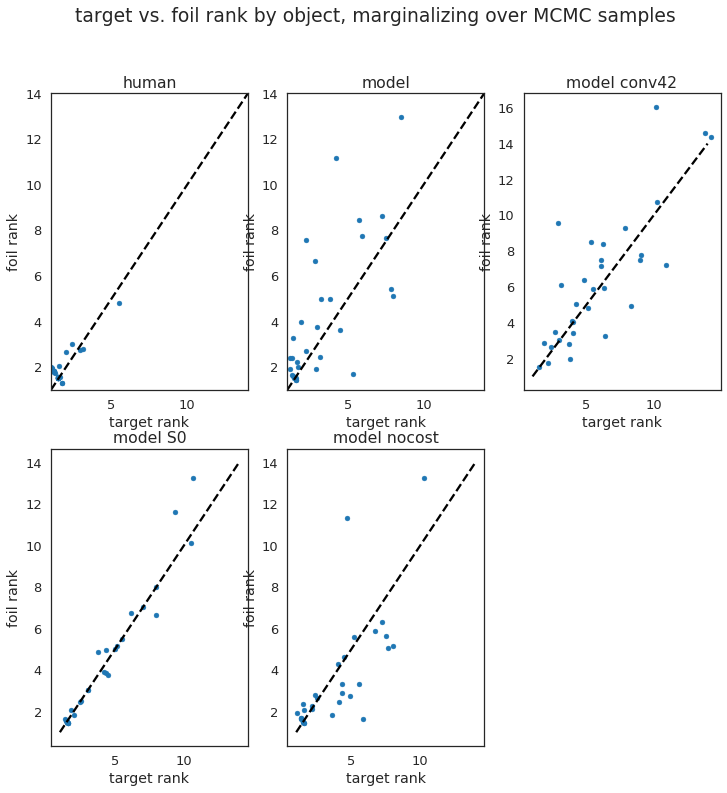

In [749]:
## what is the rank of the correct sketch category vs. wrong context condition, but correct object
fig = plt.figure(figsize=(12,12))
plt.suptitle('target vs. foil rank by object, marginalizing over MCMC samples')
plt.subplot(231)
targ = pd.DataFrame(H.groupby(['object'])['target_rank'].mean())['target_rank'].values
foil = pd.DataFrame(H.groupby(['object'])['foil_rank'].mean())['foil_rank'].values
h = plt.scatter(targ,foil,s=24)
plt.plot([1,14],[1,14],color='k',linestyle='dashed')
plt.xlim([1,14])
plt.ylim([1,14])
plt.xlabel('target rank')
plt.ylabel('foil rank')
plt.title('human')
plt.subplot(232)
targ = pd.DataFrame(M.groupby(['object'])['target_rank'].mean())['target_rank'].values
foil = pd.DataFrame(M.groupby(['object'])['foil_rank'].mean())['foil_rank'].values
h = plt.scatter(targ,foil,s=24)
plt.plot([1,14],[1,14],color='k',linestyle='dashed')
plt.xlim([1,14])
plt.ylim([1,14])
plt.xlabel('target rank')
plt.ylabel('foil rank')
plt.title('model')
plt.subplot(233)
targ = pd.DataFrame(M0.groupby(['object'])['target_rank'].mean())['target_rank'].values
foil = pd.DataFrame(M0.groupby(['object'])['foil_rank'].mean())['foil_rank'].values
h = plt.scatter(targ,foil,s=24)
plt.plot([1,14],[1,14],color='k',linestyle='dashed')
# plt.xlim([1,14])
# plt.ylim([1,14])
plt.xlabel('target rank')
plt.ylabel('foil rank')
plt.title('model conv42')
plt.subplot(234)
targ = pd.DataFrame(M1.groupby(['object'])['target_rank'].mean())['target_rank'].values
foil = pd.DataFrame(M1.groupby(['object'])['foil_rank'].mean())['foil_rank'].values
h = plt.scatter(targ,foil,s=24)
plt.plot([1,14],[1,14],color='k',linestyle='dashed')
# plt.xlim([1,14])
# plt.ylim([1,14])
plt.xlabel('target rank')
plt.ylabel('foil rank')
plt.title('model S0')
plt.subplot(235)
targ = pd.DataFrame(M2.groupby(['object'])['target_rank'].mean())['target_rank'].values
foil = pd.DataFrame(M2.groupby(['object'])['foil_rank'].mean())['foil_rank'].values
h = plt.scatter(targ,foil,s=24)
plt.plot([1,14],[1,14],color='k',linestyle='dashed')
# plt.xlim([1,14])
# plt.ylim([1,14])
plt.xlabel('target rank')
plt.ylabel('foil rank')
plt.title('model nocost')

In [751]:
print H['target_rank'].mean(), H['foil_rank'].mean()
print M['target_rank'].mean(), M['foil_rank'].mean()
print M0['target_rank'].mean(), M0['foil_rank'].mean()
print M1['target_rank'].mean(), M1['foil_rank'].mean()
print M2['target_rank'].mean(), M2['foil_rank'].mean()

1.6374420289855072 1.8757282608695651
3.3430072463768115 4.101047101449275
5.852333333333333 6.350438405797101
3.9001376811594204 3.994496376811594
3.760268115942029 3.439394927536232


In [752]:
### make a "top-k" plot (what percentage of sketches in the top k)

model_space = ['human_combined_cost','multimodal_fc6_combined_cost','multimodal_conv42_combined_cost',
              'multimodal_fc6_S0_cost','multimodal_fc6_combined_nocost']

dfs = H,M,M0,M1,M2

model_df_dict = dict(zip(model_space,dfs))

for j,model in enumerate(model_space):
    print '{} evaluating {}'.format(j,model)
    clear_output(wait=True)        
    D = model_df_dict[model]   
    
    sample_inds = np.unique(D.sample_ind.values)
    prop = []
    sid = []
    K = []
    for i,sample_ind in enumerate(sample_inds):
        if i%250==0:
            print 'evaluating {}'.format(i)
        these_rows = D[D['sample_ind']==sample_ind]
        num_trials = these_rows.shape[0]
        for k in np.arange(1,65):
            prop.append(sum(these_rows['target_rank']<=k)/num_trials)
            sid.append(sample_ind)
            K.append(k)

    ## make dataframe and save out
    sid = map(int,sid)
    K = map(int,K)
    adaptor = list(np.tile(model,len(sid)))
    Q = pd.DataFrame([prop,sid,K,adaptor])
    Q = Q.transpose()
    Q.columns = ['prop','ind','k','adaptor']
    print model, split_type
    Q.to_csv('./csv/{}_{}_topk.csv'.format(model,split_type),index=False)        

evaluating 750
multimodal_fc6_combined_nocost balancedavg1


In [764]:
## aggregate across comparison models
QH = pd.read_csv('./csv/human_combined_cost_balancedavg1_topk.csv')
QM = pd.read_csv('./csv/multimodal_fc6_combined_cost_balancedavg1_topk.csv')
QM0 = pd.read_csv('./csv/multimodal_conv42_combined_cost_balancedavg1_topk.csv')
QM1 = pd.read_csv('./csv/multimodal_fc6_S0_cost_balancedavg1_topk.csv')
QM2 = pd.read_csv('./csv/multimodal_fc6_combined_nocost_balancedavg1_topk.csv')
Q = pd.concat([QH,QM0,QM1,QM2,QM],axis=0)

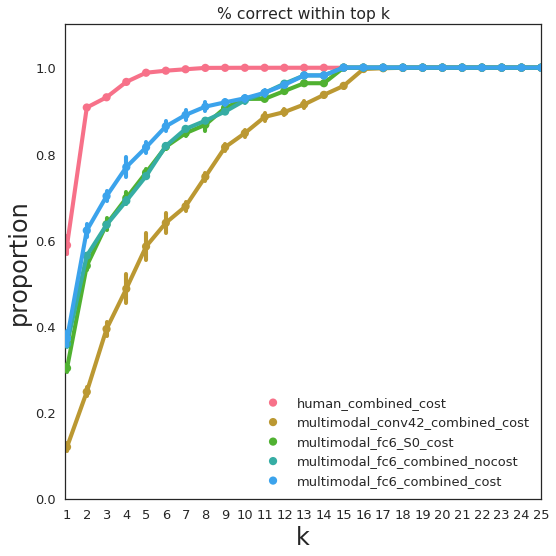

In [778]:
## plot it
krange = 64 ## how many values of k to plot
sns.set_context('talk')
fig = plt.figure(figsize=(8,8))
colors = sns.color_palette('husl',6)
sns.pointplot(x='k',
              y='prop',
              hue='adaptor',
              data=Q,
              palette=colors,
              markers = '.',
              ci='sd',              
              join=True)
plt.ylabel('proportion',fontsize=24)
plt.xlabel('k',fontsize=24)
plt.title('% correct within top k')
plt.ylim([0,1.1])
# plt.xlim([-0.1,krange])
plt.xlim([-0.1,24])
# locs, labels = plt.xticks(np.linspace(0,krange-1,9),map(int,np.linspace(0,krange-1,9)+1),fontsize=16)
plt.tight_layout()
plt.legend()

In [ ]:
### show the average cost (time, strokes, ink) for average model prediction

In [25]:
reallyRun = 0
if reallyRun:
    import analysis_helpers as h
    reload(h)

    for this_model in model_zoo:

        ## define paths to model predictions
        path_to_evaluate = '/data2/jefan/sketchpad_basic_model_output/evaluateOutput'
        model_dirname = ('_').join(this_model.split('_')[:4])
        pred_path = os.path.join(path_to_evaluate,model_dirname)

        ## get file with params from this model
        this_params = os.path.join('../models/bdaOutput',this_model)
        params = pd.read_csv(this_params)
        assert np.round(np.sum(np.exp(params.posteriorProb.values)),12)==1

        ## get list of all predictives (accepted MCMC samples)
        pred_files = [i for i in os.listdir(pred_path) if i[-15:] =='Predictives.csv']
        h.sort_filelist(pred_files) ## sort pred_files into human ordering

        X = [] ## initialize giant dataframe that contains predictions from all MCMC samples

        ## loop through MCMC samples
        for i,this_sample in enumerate(pred_files):
            print 'Currently evaluating {}'.format(model_dirname)
            print'{} | sample ID: {} '.format(i,int(this_sample.split('Predictives.csv')[0]))
            ## read in predictions from this sample
            sample_path = os.path.join(pred_path,this_sample)
            sample_preds = pd.read_csv(sample_path)
            sample_ind = int(this_sample.split('Predictives.csv')[0]) ## index of MCMC sample
            clear_output(wait=True)

            #### get params that generated these predictions
            #alpha = params.iloc[sample_ind]['alpha']
            #simScaling = params.iloc[sample_ind]['simScaling']
            #pragWeight = params.iloc[sample_ind]['pragWeight']
            #costWeight = params.iloc[sample_ind]['costWeight']
            posteriorProb = params.iloc[sample_ind]['posteriorProb']
            #logLikelihood = params.iloc[sample_ind]['logLikelihood']

            ## get congruent/incongruent context log odds for each sketch
            sketches = np.unique(sample_preds['trueSketch'].values)
            log_odds = []
            label = []
            condition = []
            cp = []
            op = []
            for this_sketch in sketches:
                sketch_inds = sample_preds['trueSketch']==this_sketch
                these_rows = sample_preds[sketch_inds]
                cond = np.unique(these_rows['condition'].values)[0]
                other_cond = [i for i in ['closer','further'] if i != cond][0]
                obj = these_rows.iloc[0]['Target'].split('_')[-1]
                congruent_prob = these_rows[these_rows['coarseGrainedPossibleSketch']=='{}_{}'.format(cond,obj)]['modelProb'].values[0]
                other_prob = these_rows[these_rows['coarseGrainedPossibleSketch']=='{}_{}'.format(other_cond,obj)]['modelProb'].values[0]
                log_odds.append(congruent_prob - other_prob)
                cp.append(congruent_prob)
                op.append(other_prob)
                label.append(obj)
                condition.append(cond)  

            ## make dataframe out of this sample
            sampleProb = [posteriorProb]*len(condition) ## take exp of posteriorProb, which is already in log space
            sampleInd = [sample_ind]*len(conditiond)
            x = pd.DataFrame([sampleInd,sampleProb,condition,label,list(sketches),log_odds,cp,op])
            x = x.transpose()
            x.columns = ['sample_ind','sample_logprob','condition','label','sketch','odds','congruent_prob','other_prob']
            x = x.sort_values(by=['condition','label','sketch'])

            ## concatenate dataframes containing log-odds from all MCMC samples
            if len(X)==0:
                X = x
            else:
                X = pd.concat([X,x])

        # save out   
        X.odds = X.odds.astype('float')
        X.sample_prob = X.sample_prob.astype('float')
        print 'Saving out model predictions for {}'.format(model_dirname)
        X.to_csv('./predictions/{}_model_predictions_log_odds.csv'.format(model_dirname))

### analyze pattern of model predictions

In [551]:
### helpers
def bootstrapCI(x,nIter=1000):
    '''
    input: x is an array
    '''
    u = []
    for i in np.arange(nIter):
        inds = np.random.RandomState(i).choice(len(x),len(x))
        boot = x[inds]
        u.append(np.mean(boot))

    u = np.array(u)
    p1 = sum(u<0)/len(u) * 2
    p2 = sum(u>0)/len(u) * 2
    p = np.min([p1,p2])
    U = np.mean(u)
    lb = np.percentile(u,2.5)
    ub = np.percentile(u,97.5)
    return U,lb,ub,p

def sumlogprob(a,b):
    if (a > b):
        return a + np.log1p(np.exp(b-a))
    else:
        return b + np.log1p(np.exp(a-b)) 
    
def flatten(x):
    return [item for sublist in x for item in sublist]
    
    
def make_category_by_obj_palette():
    import itertools
    col = []
    for j in sns.color_palette("hls", 4):
        col.append([i for i in itertools.repeat(j, 8)])
    return flatten(col)    

In [538]:
for this_model in ['multimodal_full25k_combined_cost','multimodal_full25k_combined_nocost',\
                  'multimodal_full25k_S0_cost','multimodal_full25k_S0_nocost']:
    X = pd.read_csv('./predictions/{}_model_predictions_log_odds.csv'.format(this_model))
    try:
        X.rename(columns={'sample_prob':'sample_logprob'},inplace=True)
    except:
        print 'No column called sample_prob'


    ## get sample_prob in prob space by exponentiating sample_logprob    
    X['sample_prob'] = np.exp(X['sample_logprob'].values)
    ## sample_prob is already in prob space, congruent_prob is in log space
    X['weighted_congruent_prob'] = X['sample_prob']*np.exp(X['congruent_prob']) 
    X['weighted_other_prob'] = X['sample_prob']*np.exp(X['other_prob']) 

    assert np.round(X.groupby('sample_ind')['sample_prob'].mean().sum(),1)==1    

    ## which is the MAP sample?
    # MAP_sample_ind = X[X['sample_logprob']==np.max(X['sample_logprob'])]['sample_ind'].unique()[0]
    # XMAP = X[X['sample_ind']==MAP_sample_ind]

    ## make dataframe collapsed down to sketch level marginalizing over parameter values
    ## extract weighted congruent_prob and other_prob for each sketch
    CP = X.groupby('sketch')['weighted_congruent_prob'].sum().values
    OP = X.groupby('sketch')['weighted_other_prob'].sum().values
    COND = [i[0] for i in X.groupby('sketch')['condition'].unique().values]
    LABEL = [i[0] for i in X.groupby('sketch')['label'].unique().values]
    
    ## actually make dataframe
    P = pd.DataFrame([CP,OP,COND,LABEL]).transpose()
    P.columns = ['congruent_prob','other_prob','condition','label']
    P.congruent_prob = P.congruent_prob.astype('float')
    P.other_prob = P.other_prob.astype('float')
    P['total_class_prob'] = P['congruent_prob']+P['other_prob']
    P.total_class_prob = P.total_class_prob.astype('float')
    P['normalized_congruent_prob'] = P['congruent_prob']/P['total_class_prob']
    P['normalized_other_prob'] = P['other_prob']/P['total_class_prob']

    log_odds = np.log(P['congruent_prob'].values/P['other_prob'].values)
    P = P.assign(log_odds=pd.Series(log_odds).values)
    model_name = [this_model]*len(log_odds)
    perception = [this_model.split('_')[0]]*len(log_odds)
    pragmatics = [this_model.split('_')[-2]]*len(log_odds)
    production = [this_model.split('_')[-1]]*len(log_odds)
    P = P.assign(model_name = pd.Series(model_name).values) ## add model name to the dataframe
    P = P.assign(perception = pd.Series(perception).values)
    P = P.assign(pragmatics = pd.Series(pragmatics).values)
    P = P.assign(production = pd.Series(production).values) 

    sketch_id = np.arange(P.shape[0])
    P = P.assign(sketch_id = pd.Series(sketch_id).values)
    ## write out model decisions
    P.to_csv('./predictions/{}_model_predictions_log_odds_sketch_level.csv'.format(this_model),index=False)
        
    U,lb,ub,p = bootstrapCI(log_odds)    
    print np.round(U,3),np.round(lb,3),np.round(ub,3),np.round(p,3), this_model

0.236 0.166 0.308 0.0 multimodal_full25k_combined_cost
0.199 0.126 0.275 0.0 multimodal_full25k_combined_nocost
0.203 0.096 0.318 0.0 multimodal_full25k_S0_cost
0.163 0.095 0.231 0.0 multimodal_full25k_S0_nocost


### read in sketcher model predictions collapsed down to sketch level

In [539]:
PC = pd.read_csv('./predictions/multimodal_full25k_combined_cost_model_predictions_log_odds_sketch_level.csv')
PN = pd.read_csv('./predictions/multimodal_full25k_combined_nocost_model_predictions_log_odds_sketch_level.csv')
LC = pd.read_csv('./predictions/multimodal_full25k_S0_cost_model_predictions_log_odds_sketch_level.csv')
LN = pd.read_csv('./predictions/multimodal_full25k_S0_nocost_model_predictions_log_odds_sketch_level.csv')
M = pd.concat([PC,PN,LC,LN],axis=0)
M.reset_index(inplace=True)
M0 = M[['log_odds','sketch_id','pragmatics','production','model_name']]
M0.to_csv('./predictions/multimodal_full25k_all_variants_log_odds_sketch_level.csv')

In [540]:
M.head()

,index,congruent_prob,other_prob,condition,label,total_class_prob,normalized_congruent_prob,normalized_other_prob,log_odds,model_name,perception,pragmatics,production,sketch_id
0,0,0.325487,0.534660,closer,straight,0.860146,0.378408,0.621592,-0.496309,multimodal_full25k_combined_cost,multimodal,combined,cost,0
1,1,0.139640,0.091987,closer,leather,0.231627,0.602867,0.397133,0.417424,multimodal_full25k_combined_cost,multimodal,combined,cost,1
2,2,0.055857,0.051921,further,brown,0.107778,0.518262,0.481738,0.073080,multimodal_full25k_combined_cost,multimodal,combined,cost,2
3,3,0.076573,0.067624,further,redantique,0.144197,0.531028,0.468972,0.124272,multimodal_full25k_combined_cost,multimodal,combined,cost,3
4,4,0.178372,0.043862,further,inlay,0.222234,0.802630,0.197370,1.402815,multimodal_full25k_combined_cost,multimodal,combined,cost,4


In [579]:
this_model

'multimodal_full25k_S0_nocost'

#### make multimodal log odds plot

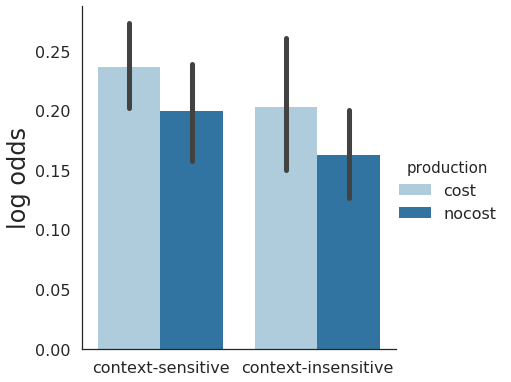

In [725]:
colors = sns.color_palette("Dark2")
sns.set_context('poster')
sns.factorplot(x='pragmatics',
               hue='production',
               y='log_odds',
               data=M, size=6, kind='bar',palette='Paired',ci=68)
plt.ylabel('log odds',fontsize=24)
plt.xlabel(' ',fontsize=24)
locs, labels = plt.xticks([0,1],['context-sensitive','context-insensitive'],fontsize=16)
plt.savefig('./plots/{}_context_effect_log_odds_by_model_bars.pdf'.format(this_model.split('_')[0]))

In [529]:
diff = PC['log_odds'].values-PN['log_odds'].values
U,lb,ub,p = bootstrapCI(diff)
print U,lb,ub,p

diff = LC['log_odds'].values-LN['log_odds'].values
U,lb,ub,p = bootstrapCI(diff)
print U,lb,ub,p

diff = PC['log_odds'].values-LC['log_odds'].values
U,lb,ub,p = bootstrapCI(diff)
print U,lb,ub,p

0.036619062634156097 0.009392008086820242 0.06339017901571752 0.01
0.040616846072532485 -0.008445935244348604 0.09445570806948728 0.128
0.03274163944637461 -0.02657488732987849 0.08730852232326353 0.262


#### broken down by class

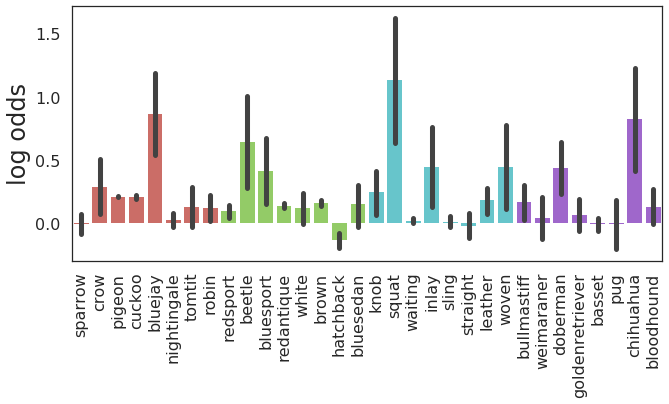

In [581]:
colors32 = make_category_by_obj_palette()
fig = plt.figure(figsize=(10,6))
sns.barplot(data=PC,
            x='label',
            order=obj_list,
            y='log_odds',
            palette=colors32,ci=68)
h = plt.xticks(range(len(obj_list)), obj_list, fontsize=16,rotation='vertical')
plt.ylabel('log odds',fontsize=24)
plt.xlabel('')
plt.tight_layout()
plt.savefig('./plots/{}_log_odds_ratio_congruent_sketch_type_in_context.pdf'.format(this_model.split('_')[0]))

In [ ]:
### how log odds behaves
p1 = 0.27*2.7*2.7
p2 = 0.1
print np.log(p1/p2)

#### calculate proportion of objects for which model able to predict correct condition+obj sketch category

In [627]:
_P = pd.read_csv('multimodal_full25k_combined_cost_aggregatedPredictives_longform.csv')

In [628]:
_P.head()

,trueSketch,possibleSketch,coarseGrainedTrueSketch,weighted
0,08711b390cfc_17,closer_basset,closer_straight,-8.651603
1,08711b390cfc_17,closer_beetle,closer_straight,-10.721931
2,08711b390cfc_17,closer_bloodhound,closer_straight,-13.805462
3,08711b390cfc_17,closer_bluejay,closer_straight,-11.182569
4,08711b390cfc_17,closer_bluesedan,closer_straight,-14.089705


In [632]:
## get dataframe with probability assigned to every sketch category, for each sketch category
P = _P.groupby(['coarseGrainedTrueSketch','possibleSketch'])['weighted'].\
apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))

## generate 4096x7ish dataframe with log probabilities already aggregated at course condition&object level
P = pd.DataFrame(P)
P.reset_index(inplace=True)
P['trueCondition'], P['trueSketchTarget'] = P['coarseGrainedTrueSketch'].str.split('_', 1).str
P['predCondition'], P['predSketchTarget'] = P['possibleSketch'].str.split('_', 1).str

In [636]:
P.head()

,coarseGrainedTrueSketch,possibleSketch,weighted,trueCondition,trueSketchTarget,predCondition,predSketchTarget
0,closer_basset,closer_basset,-2.348282,closer,basset,closer,basset
1,closer_basset,closer_beetle,-3.609396,closer,basset,closer,beetle
2,closer_basset,closer_bloodhound,-3.296828,closer,basset,closer,bloodhound
3,closer_basset,closer_bluejay,-7.167444,closer,basset,closer,bluejay
4,closer_basset,closer_bluesedan,-3.989862,closer,basset,closer,bluesedan


'closer'

In [650]:
## calculate proportion of objects for which model able to predict correct condition+obj sketch category
## i.e., put in top k, for various values of k
from __future__ import division
objs = np.unique(P['trueSketchTarget'].values)
conds = np.unique(P['trueCondition'].values)

Counter = []
Conds = []
K = []
for cond in conds:
    print 'Analyzing {}'.format(cond)
    for k in np.arange(1,64):
        counter = 0
        for obj in objs:    
            Q = P[(P['trueSketchTarget']==obj) & (P['trueCondition']==cond)].\
            nlargest(k,'weighted')[['coarseGrainedTrueSketch','possibleSketch','trueCondition','weighted']]  
            counter += np.sum(Q['possibleSketch']==Q['coarseGrainedTrueSketch'])
        Counter.append(counter/len(objs))
        Conds.append(cond)
        K.append(k)

Analyzing closer
Analyzing further


In [651]:
## make dataframe         
D = pd.DataFrame([Counter,Conds,K])
D = D.transpose()
D.columns = ['prop','condition','k']

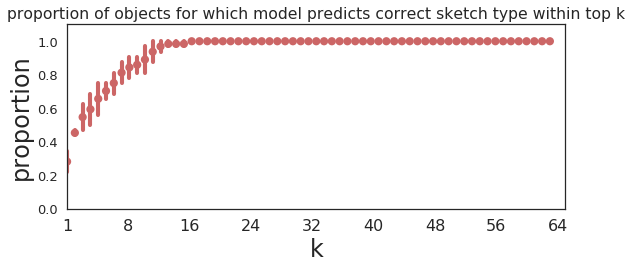

In [678]:
## plot it
krange = 64 ## how many values of k to plot
sns.set_context('talk')
fig = plt.figure(figsize=(9,4))
# sns.pointplot(x='k',y='prop',hue='condition',data=D,markers='.',palette=colors)
sns.pointplot(x='k',y='prop',data=D,markers='.',palette=[(0.8,0.4,0.4)])
plt.xlim([0,krange])
plt.ylabel('proportion',fontsize=24)
plt.xlabel('k',fontsize=24)
plt.title('proportion of objects for which model predicts correct sketch type within top k')
plt.ylim([0,1.1])
locs, labels = plt.xticks(np.linspace(0,krange-1,9),map(int,np.linspace(0,krange-1,9)+1),fontsize=16)
plt.tight_layout()
plt.savefig('./plots/{}_proportion_correct_sketch_type_in_top_k.pdf'.format(this_model))